In [53]:
torch.__version__

'1.4.0'

In [30]:
import os
import sys
import json
import ipaddress
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split

class Resource:
  def __init__(self, RequestID, Site, LoadURL, LoadDomain, 
      Type, MimeType, RemoteIPAddr, ModTime):
    self.request_id = RequestID
    self.site = Site
    self.load_url = LoadURL
    self.load_domain = LoadDomain
    self.resource_type = Type
    self.mimetype = MimeType
    self.ip_addr = RemoteIPAddr
    self.mod_time = ModTime

# Function to parse and create Resources from JSON
def extract_from_JSON(filename):
    ip_to_occurrences = dict()
    ip_to_sites = dict()
    site_date_ipset = dict()
    with open(filename) as f:
        for line in f:
            data = json.loads(line)
            resource = Resource(data["RequestID"], data["Site"], data["LoadURL"], 
                                data["LoadDomain"], data["Type"], data["MimeType"], 
                                data["RemoteIPAddr"], data["ModTime"])
            
            # For ip occurrence filtering in entire dataset
            ip_to_occurrences.setdefault(resource.ip_addr, set())
            occurrence_event = resource.mod_time + " " + resource.site
            ip_to_occurrences[resource.ip_addr].add(occurrence_event)
    
            # For ips unique to a website
            ip_to_sites.setdefault(resource.ip_addr, set())
            ip_to_sites[resource.ip_addr].add(resource.site)
            
            # extracting samples
            site_date_ipset.setdefault(resource.site, dict())
            site_date_ipset[resource.site].setdefault(resource.mod_time, set())
            site_date_ipset[resource.site][resource.mod_time].add(resource.ip_addr)
    return ip_to_occurrences, ip_to_sites, site_date_ipset

In [31]:
filename = "../output/02-06-2020_1000-recurring_output.json"
ip_to_occurrences, ip_to_sites, site_date_ipset = extract_from_JSON(filename)

In [32]:
print(len(site_date_ipset), len(ip_to_occurrences), len(ip_to_sites))

974 54622 54622


In [33]:
# filtering passes: 
ips_to_remove = set()
for ip in ip_to_occurrences:
    occurrences = ip_to_occurrences[ip]
    if len(occurrences) < 20:
       ips_to_remove.add(ip)

for ip in ips_to_remove:
    try:
        del ip_to_occurrences[ip]
        del ip_to_sites[ip]
    except KeyError:
        print(ip, " Not Present")
     
unique_ip_to_site = dict()
# Does it make sense to filter the site out?
for ip in ip_to_sites:
    if len(ip_to_sites[ip]) == 1:
        site = ip_to_sites[ip].pop()
        unique_ip_to_site[ip] = site
        try:
            del site_date_ipset[site]
        except KeyError:
            pass
            #print(site, " Not Present in map")
        try:
            del ip_to_occurrences[ip]
        except KeyError:
            pass
            #print(ip, " Not Present")

# ip_to_occurrences holds all ips after filtering

In [96]:
print(len(site_date_ipset))

193


In [97]:
# create site to encoded ipset mapping
labels = []
encodings = []
all_ips = list(ip_to_occurrences.keys())
print(len(all_ips))
for site in site_date_ipset:
    date_to_ipset = site_date_ipset[site]
    for date in date_to_ipset:
        ipset = date_to_ipset[date]
        iparray = [0] * len(all_ips)
        for ip in ipset:
            if ip in ip_to_occurrences:
                iparray[all_ips.index(ip)] = 1
        labels.append(site)
        encodings.append(np.asarray(iparray))

print(len(labels), len(encodings))
                

9760
20786 20786


In [98]:
import pyasn
asndb = pyasn.pyasn('pyasn')
asn_set = set()
ip_to_asn = dict()
for ip in ip_to_occurrences:
    try:
        asn,_= asndb.lookup(ip)
        ip_to_asn[ip] = asn
        asn_set.add(asn)
    except:
        print(ip, " not mapped to asn")
        continue

  not mapped to asn


In [99]:
sites_asn = []
asn_enc = []
asn_list = list(asn_set)
for site in site_date_ipset:
    date_to_ipset = site_date_ipset[site]
    for date in date_to_ipset:
        ipset = date_to_ipset[date]
        asn_array = [0]*len(asn_list)
        for ip in ipset:
            if ip in ip_to_occurrences:
                try:
                    asn_array[asn_list.index(ip_to_asn[ip])] = 1
                except Exception as e:
                    continue
        sites_asn.append(site)
        asn_enc.append(np.asarray(asn_array))

In [100]:
print(len(sites_asn[0]), len(asn_enc[0]))
print(len(labels[0]), len(encodings[0]))

1 346
1 9760


In [124]:
import torch.nn.functional as F
class NNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 400)
#         self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(400, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
#         x = self.fc2(x)
        return self.fc3(x)

In [125]:
from sklearn import preprocessing
import torch

tensor_encodings = torch.Tensor(encodings)
le_labels = preprocessing.LabelEncoder()
tensor_labels = le_labels.fit_transform(labels)
tensor_labels = torch.as_tensor(tensor_labels)

tensor_asn_enc = torch.Tensor(asn_enc)
le_asn = preprocessing.LabelEncoder()
tensor_sites_asn = le_asn.fit_transform(sites_asn)
tensor_sites_asn = torch.as_tensor(tensor_sites_asn)

In [126]:
import torch.utils.data as data

ip_dataset = data.TensorDataset(tensor_encodings,tensor_labels)
asn_dataset = data.TensorDataset(tensor_asn_enc,tensor_sites_asn)

In [127]:
batch_size = 64
validation_split = .2
# shuffle_dataset = True
shuffle_dataset = False
# random_seed= 42

In [160]:
train_size = int(0.8 * len(asn_dataset))
test_size = len(asn_dataset) - train_size
asn_train_dataset, asn_test_dataset = torch.utils.data.random_split(asn_dataset, [train_size, test_size])
asn_train_loader = torch.utils.data.DataLoader(asn_train_dataset, batch_size=batch_size, shuffle=True)
asn_test_loader = torch.utils.data.DataLoader(asn_test_dataset, batch_size=batch_size, shuffle=True)
print(len(asn_train_loader.dataset), len(asn_test_loader.dataset))

16628 4158


In [161]:
train_size = int(0.8 * len(ip_dataset))
test_size = len(ip_dataset) - train_size
ip_train_dataset, ip_test_dataset = torch.utils.data.random_split(ip_dataset, [train_size, test_size])
ip_train_loader = torch.utils.data.DataLoader(ip_train_dataset, batch_size=batch_size, shuffle=True)
ip_test_loader = torch.utils.data.DataLoader(ip_test_dataset, batch_size=batch_size, shuffle=True)
print(len(ip_train_loader.dataset), len(ip_test_loader.dataset))

16628 4158


In [162]:
print (len(ip_train_loader)) 
print (len(ip_test_loader))

260
65


In [163]:
input_size_ipdataset = len(tensor_encodings[0])
output_size_ipdataset = len(site_date_ipset)
embed_size_ipdataset = 1000

input_size_asndataset = len(tensor_asn_enc[0])
output_size_asndataset = len(site_date_ipset)
embed_size_asndataset = 270
print(input_size_ipdataset, output_size_ipdataset)
print(input_size_asndataset, output_size_asndataset)

9760 193
346 193


In [164]:
model_ip = NNet(input_size_ipdataset, output_size_ipdataset)
model_asn = NNet(input_size_asndataset, output_size_asndataset)

In [165]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer_ip = torch.optim.SGD(model_ip.parameters(), lr=0.5)
optimizer_asn = torch.optim.SGD(model_asn.parameters(), lr=0.5)

In [166]:
len(ip_test_loader.dataset)

4158

In [191]:
# Reference: https://github.com/hunkim/PyTorchZeroToAll

from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import time
device = 'cpu'

def confusion_mat(preds, labels, conf_matrix, labels_to_predicted):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        t_class = le_labels.classes_[t.item()]
        p_class = le_labels.classes_[p.item()]
        labels_to_predicted.setdefault(t_class, set())
        labels_to_predicted[t_class].add(p_class)
        conf_matrix[p, t] += 1
    
    return conf_matrix

def train(epoch, train_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() 
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return total_loss / len(train_loader)

def test(test_loader, model, conf_matrix, labels_to_predicted):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        conf_matrix = confusion_mat(output, target, conf_matrix, labels_to_predicted)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader)
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')
    return test_loss
    
    

In [192]:
# first ip dataset training and tests
since = time.time()
labels_to_predicted_ip = dict()
print(len(ip_train_loader.dataset), len(ip_test_loader.dataset))
conf_matrix_ip = torch.zeros(output_size_ipdataset, output_size_ipdataset)
train_losses, test_losses = [], []
for epoch in range(1, 10):
    epoch_start = time.time()
    epoch_train_loss = train(epoch, ip_train_loader, model_ip, optimizer_ip)
    train_losses.append(epoch_train_loss)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
    epoch_test_loss = test(ip_test_loader, model_ip, conf_matrix_ip, labels_to_predicted_ip)
    test_losses.append(epoch_test_loss)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Testing time: {m:.0f}m {s:.0f}s')

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')

print("conf mat ip: ", conf_matrix_ip)

16628 4158
Train Epoch: 1 | Batch Status: 0/16628 (0%) | Loss: 1.268109
Train Epoch: 1 | Batch Status: 640/16628 (4%) | Loss: 1.140238
Train Epoch: 1 | Batch Status: 1280/16628 (8%) | Loss: 1.117554
Train Epoch: 1 | Batch Status: 1920/16628 (12%) | Loss: 1.401176
Train Epoch: 1 | Batch Status: 2560/16628 (15%) | Loss: 1.189494
Train Epoch: 1 | Batch Status: 3200/16628 (19%) | Loss: 1.111013
Train Epoch: 1 | Batch Status: 3840/16628 (23%) | Loss: 1.113061
Train Epoch: 1 | Batch Status: 4480/16628 (27%) | Loss: 1.260854
Train Epoch: 1 | Batch Status: 5120/16628 (31%) | Loss: 0.865987
Train Epoch: 1 | Batch Status: 5760/16628 (35%) | Loss: 1.046704
Train Epoch: 1 | Batch Status: 6400/16628 (38%) | Loss: 0.959413
Train Epoch: 1 | Batch Status: 7040/16628 (42%) | Loss: 1.465474
Train Epoch: 1 | Batch Status: 7680/16628 (46%) | Loss: 1.357489
Train Epoch: 1 | Batch Status: 8320/16628 (50%) | Loss: 0.939068
Train Epoch: 1 | Batch Status: 8960/16628 (54%) | Loss: 1.062482
Train Epoch: 1 | Batc

Train Epoch: 5 | Batch Status: 8960/16628 (54%) | Loss: 1.074073
Train Epoch: 5 | Batch Status: 9600/16628 (58%) | Loss: 1.006256
Train Epoch: 5 | Batch Status: 10240/16628 (62%) | Loss: 1.209236
Train Epoch: 5 | Batch Status: 10880/16628 (65%) | Loss: 0.947363
Train Epoch: 5 | Batch Status: 11520/16628 (69%) | Loss: 1.131575
Train Epoch: 5 | Batch Status: 12160/16628 (73%) | Loss: 1.340765
Train Epoch: 5 | Batch Status: 12800/16628 (77%) | Loss: 0.976391
Train Epoch: 5 | Batch Status: 13440/16628 (81%) | Loss: 1.149237
Train Epoch: 5 | Batch Status: 14080/16628 (85%) | Loss: 1.235679
Train Epoch: 5 | Batch Status: 14720/16628 (88%) | Loss: 0.925589
Train Epoch: 5 | Batch Status: 15360/16628 (92%) | Loss: 0.959654
Train Epoch: 5 | Batch Status: 16000/16628 (96%) | Loss: 1.607539
Training time: 0m 7s
Test set: Average loss: 1.3466, Accuracy: 2519/4158 (61%)
Testing time: 0m 8s
Train Epoch: 6 | Batch Status: 0/16628 (0%) | Loss: 1.411609
Train Epoch: 6 | Batch Status: 640/16628 (4%) | Lo

In [193]:
# Now asn dataset training and tests
since = time.time()
criterion = nn.CrossEntropyLoss(reduction='mean')
print(len(asn_train_loader.dataset), len(asn_test_loader.dataset))
conf_matrix = torch.zeros(output_size_ipdataset, output_size_ipdataset)
labels_to_predicted_asn = dict()

for epoch in range(1, 10):
    epoch_start = time.time()
    train(epoch, asn_train_loader, model_asn, optimizer_asn)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
    test(asn_test_loader, model_asn, conf_matrix, labels_to_predicted_asn)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Testing time: {m:.0f}m {s:.0f}s')

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')
print("conf mat asn: ", conf_matrix)

16628 4158
Train Epoch: 1 | Batch Status: 0/16628 (0%) | Loss: 1.931578
Train Epoch: 1 | Batch Status: 640/16628 (4%) | Loss: 2.020351
Train Epoch: 1 | Batch Status: 1280/16628 (8%) | Loss: 2.176557
Train Epoch: 1 | Batch Status: 1920/16628 (12%) | Loss: 2.053255
Train Epoch: 1 | Batch Status: 2560/16628 (15%) | Loss: 2.180373
Train Epoch: 1 | Batch Status: 3200/16628 (19%) | Loss: 2.086191
Train Epoch: 1 | Batch Status: 3840/16628 (23%) | Loss: 1.801905
Train Epoch: 1 | Batch Status: 4480/16628 (27%) | Loss: 1.895903
Train Epoch: 1 | Batch Status: 5120/16628 (31%) | Loss: 1.628098
Train Epoch: 1 | Batch Status: 5760/16628 (35%) | Loss: 1.935887
Train Epoch: 1 | Batch Status: 6400/16628 (38%) | Loss: 1.928789
Train Epoch: 1 | Batch Status: 7040/16628 (42%) | Loss: 1.717284
Train Epoch: 1 | Batch Status: 7680/16628 (46%) | Loss: 2.206074
Train Epoch: 1 | Batch Status: 8320/16628 (50%) | Loss: 2.395073
Train Epoch: 1 | Batch Status: 8960/16628 (54%) | Loss: 1.623863
Train Epoch: 1 | Batc

Train Epoch: 5 | Batch Status: 10240/16628 (62%) | Loss: 1.313096
Train Epoch: 5 | Batch Status: 10880/16628 (65%) | Loss: 1.822703
Train Epoch: 5 | Batch Status: 11520/16628 (69%) | Loss: 2.342095
Train Epoch: 5 | Batch Status: 12160/16628 (73%) | Loss: 2.204119
Train Epoch: 5 | Batch Status: 12800/16628 (77%) | Loss: 1.911291
Train Epoch: 5 | Batch Status: 13440/16628 (81%) | Loss: 2.102456
Train Epoch: 5 | Batch Status: 14080/16628 (85%) | Loss: 1.357296
Train Epoch: 5 | Batch Status: 14720/16628 (88%) | Loss: 1.988570
Train Epoch: 5 | Batch Status: 15360/16628 (92%) | Loss: 1.574060
Train Epoch: 5 | Batch Status: 16000/16628 (96%) | Loss: 2.364561
Training time: 0m 1s
Test set: Average loss: 1.8908, Accuracy: 1894/4158 (46%)
Testing time: 0m 1s
Train Epoch: 6 | Batch Status: 0/16628 (0%) | Loss: 1.563351
Train Epoch: 6 | Batch Status: 640/16628 (4%) | Loss: 1.884876
Train Epoch: 6 | Batch Status: 1280/16628 (8%) | Loss: 1.899174
Train Epoch: 6 | Batch Status: 1920/16628 (12%) | Los

In [194]:
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, name, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(name+str(datetime.date(datetime.now()))+".png")
    plt.show()

In [195]:
def print_conf_mat_info(conf_matrix, n_classes, labels):
    TP = conf_matrix.diag()
    for c in range(n_classes):
        idx = torch.ones(n_classes).bool()
        idx[c] = 0
        TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
        FP = conf_matrix[c, idx].sum()
        FN = conf_matrix[idx, c].sum()

        sensitivity = (TP[c] / (TP[c]+FN))
        specificity = (TN / (TN+FP))

        print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(
            labels[c], TP[c], TN, FP, FN))
        print('Sensitivity = {}'.format(sensitivity))
        print('Specificity = {}'.format(specificity))

Class !
TP 0.0, TN 37422.0, FP 0.0, FN 0.0
Sensitivity = nan
Specificity = 1.0
Class 163.com
TP 0.0, TN 37413.0, FP 0.0, FN 9.0
Sensitivity = 0.0
Specificity = 1.0
Class 3c.tmall.com
TP 118.0, TN 37123.0, FP 101.0, FN 80.0
Sensitivity = 0.5959596037864685
Specificity = 0.9972866773605347
Class 4399.com
TP 189.0, TN 37224.0, FP 9.0, FN 0.0
Sensitivity = 1.0
Specificity = 0.9997583031654358
Class 45eijvhgj2.com
TP 40.0, TN 37122.0, FP 111.0, FN 149.0
Sensitivity = 0.21164020895957947
Specificity = 0.9970187544822693
Class 49oa3o49b6.com
TP 57.0, TN 37073.0, FP 142.0, FN 150.0
Sensitivity = 0.2753623127937317
Specificity = 0.9961843490600586
Class 52pojie.cn
TP 162.0, TN 37260.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class addthis.com
TP 207.0, TN 37215.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class adexchangegate.com
TP 153.0, TN 37269.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class amazon.com
TP 171.0, TN 37251.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Sp

Class list.tmall.com
TP 39.0, TN 37097.0, FP 109.0, FN 177.0
Sensitivity = 0.1805555522441864
Specificity = 0.9970703721046448
Class livedoor.com
TP 92.0, TN 37095.0, FP 147.0, FN 88.0
Sensitivity = 0.5111111402511597
Specificity = 0.9960528612136841
Class livedoor.jp
TP 105.0, TN 37082.0, FP 88.0, FN 147.0
Sensitivity = 0.4166666567325592
Specificity = 0.9976325035095215
Class livejasmin.com
TP 162.0, TN 37260.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class lnkfast.com
TP 50.0, TN 36868.0, FP 239.0, FN 265.0
Sensitivity = 0.1587301641702652
Specificity = 0.9935591816902161
Class login.tmall.com
TP 234.0, TN 37188.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class marca.com
TP 225.0, TN 37197.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class meetup.com
TP 225.0, TN 37197.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class mercadolibre.com.ar
TP 169.0, TN 37222.0, FP 2.0, FN 29.0
Sensitivity = 0.8535353541374207
Specificity = 0.9999462962150574
Cla

Confusion matrix, without normalization
tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 118.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 115.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 243.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 180.]])


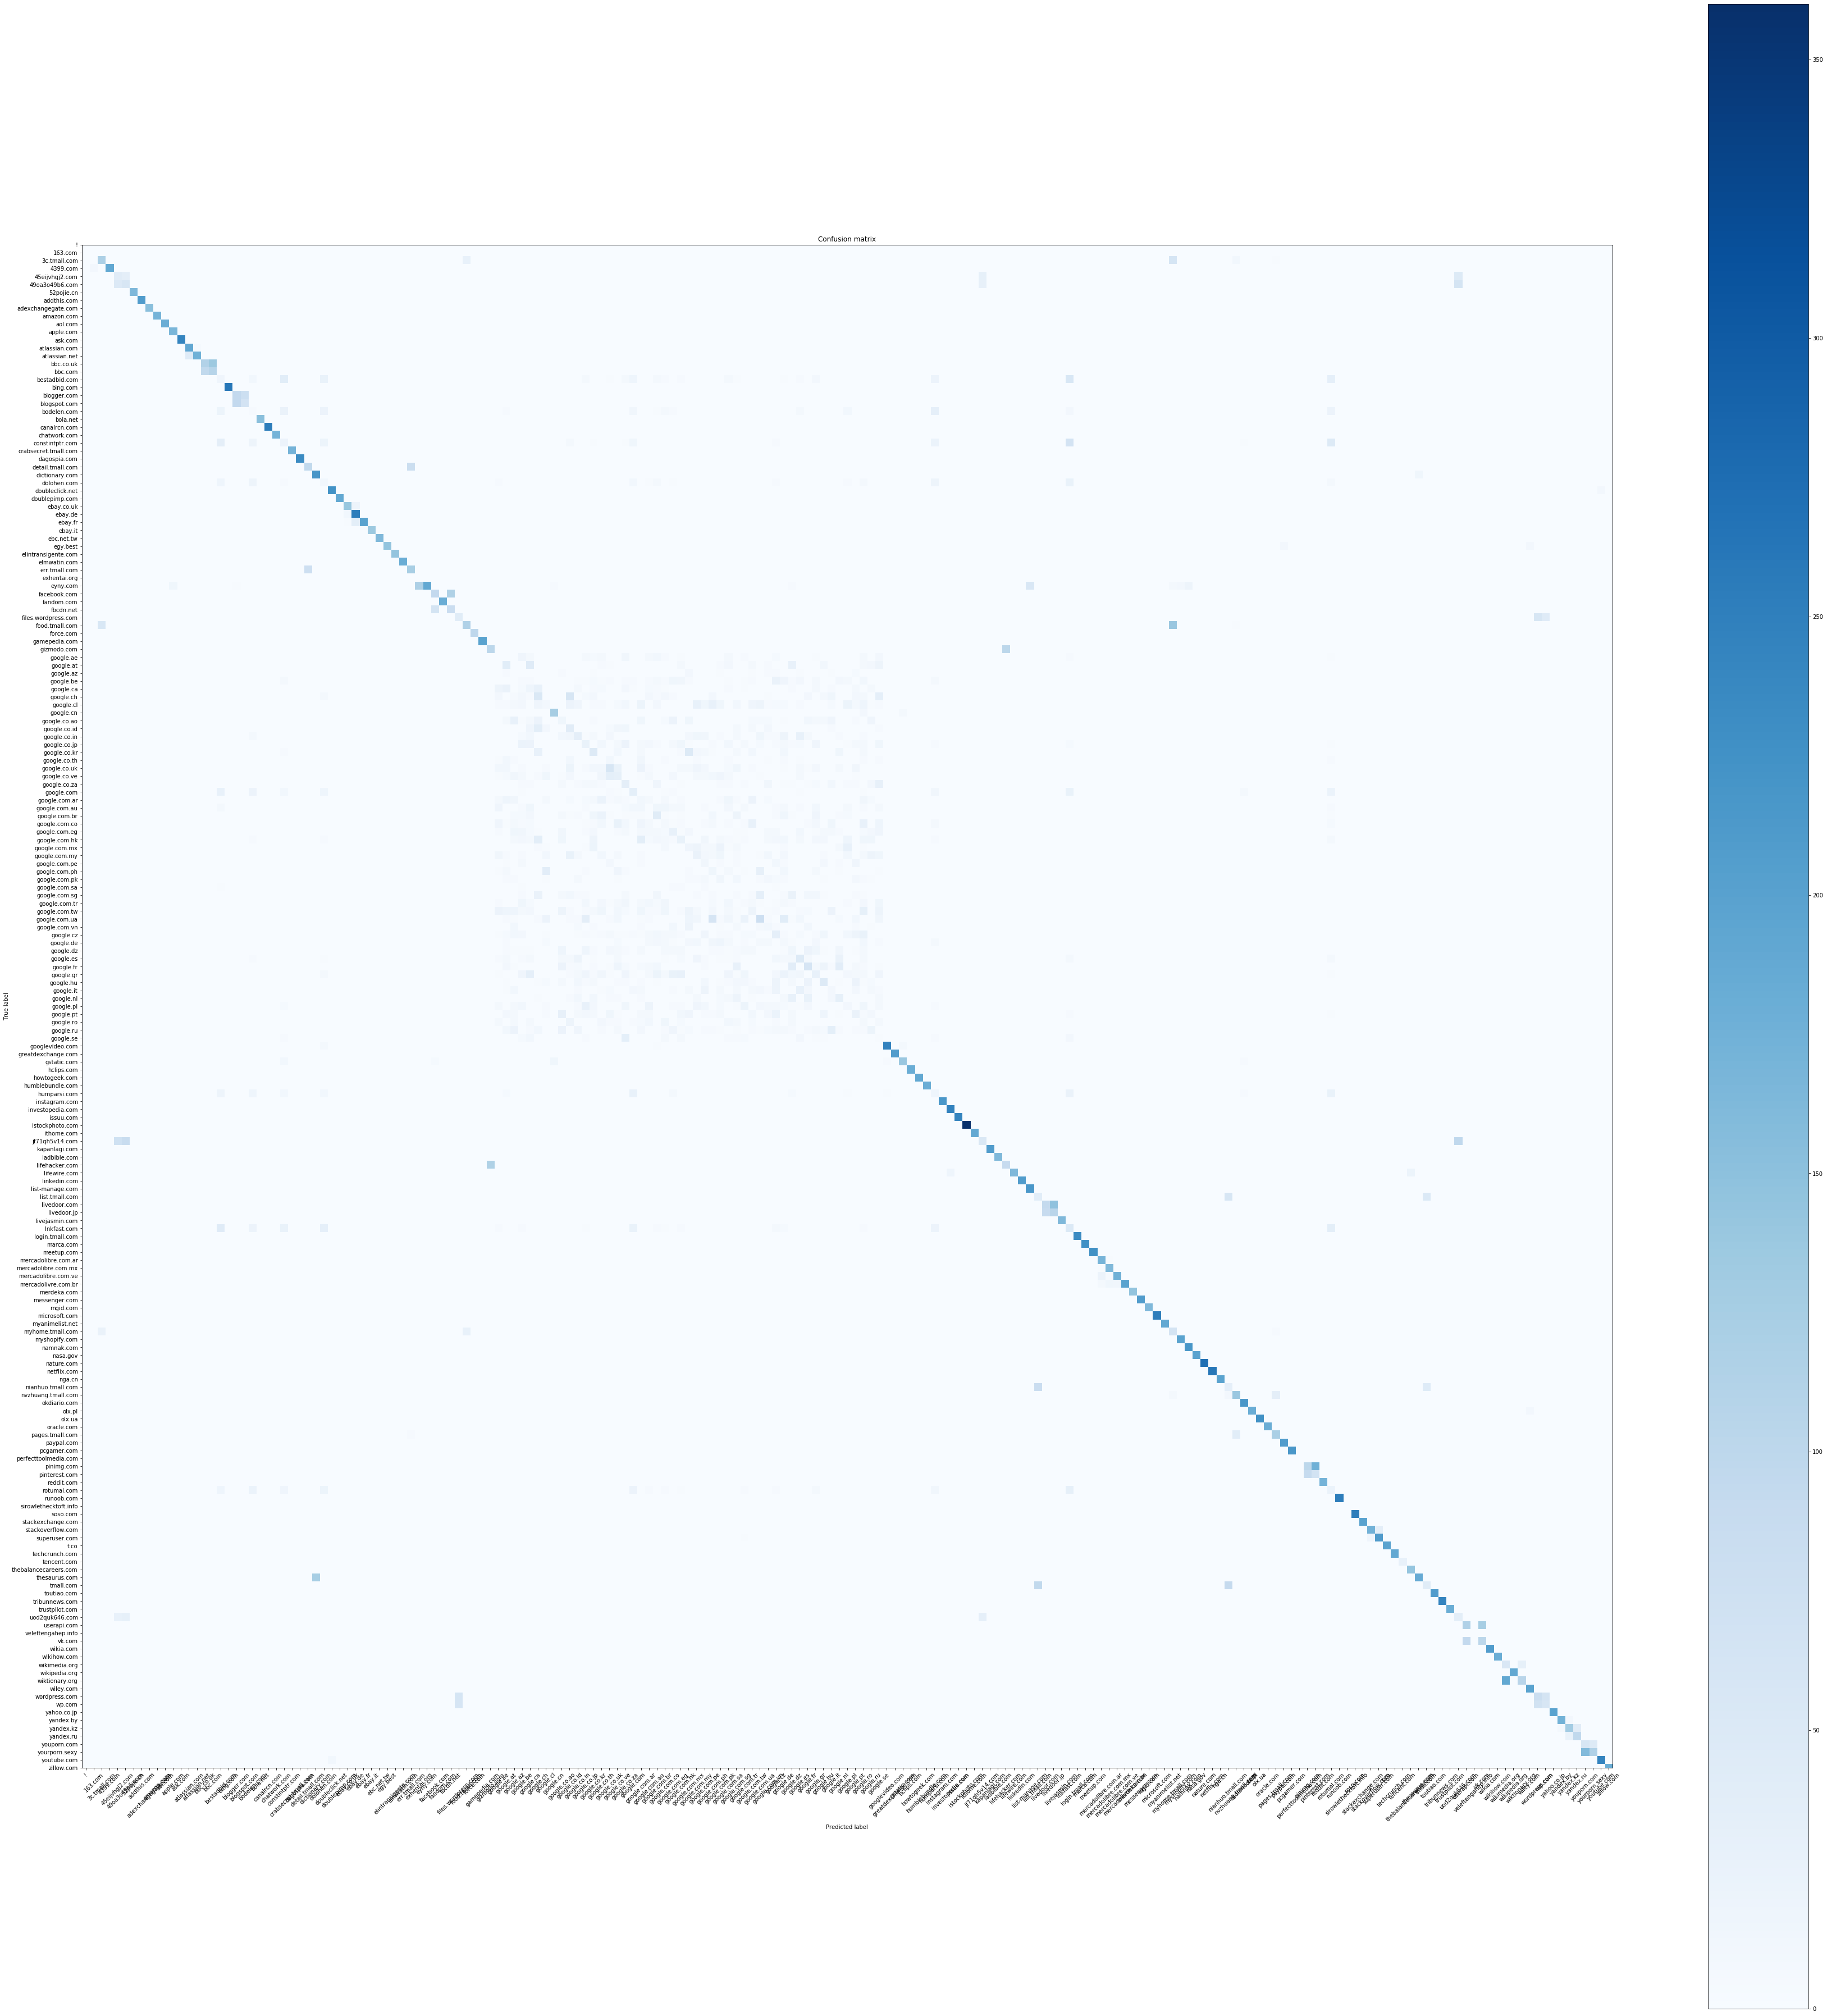

In [196]:
import itertools
print_conf_mat_info(conf_matrix_ip, output_size_ipdataset, le_labels.classes_)
print(le_labels.classes_, len(le_labels.classes_))
fig = plt.gcf()
fig.set_size_inches(50, 50)
fig.savefig("ip"+str(datetime.date(datetime.now()))+".png", dpi=100)
plot_confusion_matrix(conf_matrix_ip, le_labels.classes_, "ip", False)

In [197]:
print(conf_matrix_ip.diag())

tensor([  0.,   0., 118., 189.,  40.,  57., 162., 207., 153., 171., 180., 167.,
        243., 191., 175., 112., 107.,  15., 261.,  93.,  66.,   4., 153., 252.,
        171.,  21., 171., 234.,  95., 217.,  11., 224., 189., 140., 252., 198.,
        135., 162., 144., 144., 180., 123.,   0., 189.,  94., 180.,  82.,  41.,
        115.,  99., 198., 100.,   0.,  38.,   0.,   4.,  16.,  51.,   9., 126.,
         13.,  40.,  34.,  24.,  46.,   1.,  57.,  30.,  34.,  33.,  11.,   1.,
         42.,   6.,  27.,  25.,  15.,  23.,  12.,  14.,  12.,   0.,   4.,   4.,
         18.,  77.,  10.,  32.,   6.,  14.,  45.,  60.,  27.,  47.,   9.,  30.,
          9.,  23.,   8.,  19.,   2., 246., 207., 139., 180., 189., 180.,  16.,
        216., 245., 243., 360., 189.,  53., 207., 162.,  88., 162., 207., 216.,
         39.,  92., 105., 162.,  50., 234., 225., 225., 169., 161., 177., 198.,
        144., 207., 162., 252., 189.,  64., 198., 217., 198., 270., 261., 198.,
         31., 138., 216., 180., 225., 18

In [198]:
print(labels_to_predicted_ip)

{'google.pt': {'google.ca', 'google.dz', 'google.co.in', 'google.com.pk', 'google.cz', 'google.com.eg', 'google.com.vn', 'google.co.ve', 'google.co.uk', 'google.hu', 'google.co.jp', 'google.ru', 'google.gr', 'google.co.ao', 'google.com.sg', 'google.com.br', 'google.co.za', 'google.co.th', 'google.com.my', 'google.cl', 'google.it', 'google.ch', 'google.com.ph', 'google.pt', 'google.com.ua', 'google.az', 'google.fr', 'google.com.pe'}, 'yahoo.co.jp': {'yahoo.co.jp'}, 'wikimedia.org': {'wiktionary.org', 'wikimedia.org'}, 'canalrcn.com': {'canalrcn.com'}, 'myhome.tmall.com': {'eyny.com', 'list-manage.com', 'food.tmall.com', 'myhome.tmall.com', '3c.tmall.com', 'nvzhuang.tmall.com'}, 'investopedia.com': {'investopedia.com', 'lifewire.com'}, 'wikipedia.org': {'wikipedia.org'}, 'yourporn.sexy': {'yourporn.sexy', 'youporn.com'}, 'runoob.com': {'runoob.com'}, 'yandex.ru': {'yandex.ru', 'yandex.kz'}, 'google.ro': {'google.dz', 'google.co.in', 'google.com.tw', 'rotumal.com', 'google.com.pk', 'googl

Confusion matrix, without normalization
tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,  66.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,  96.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 108.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 153.]])


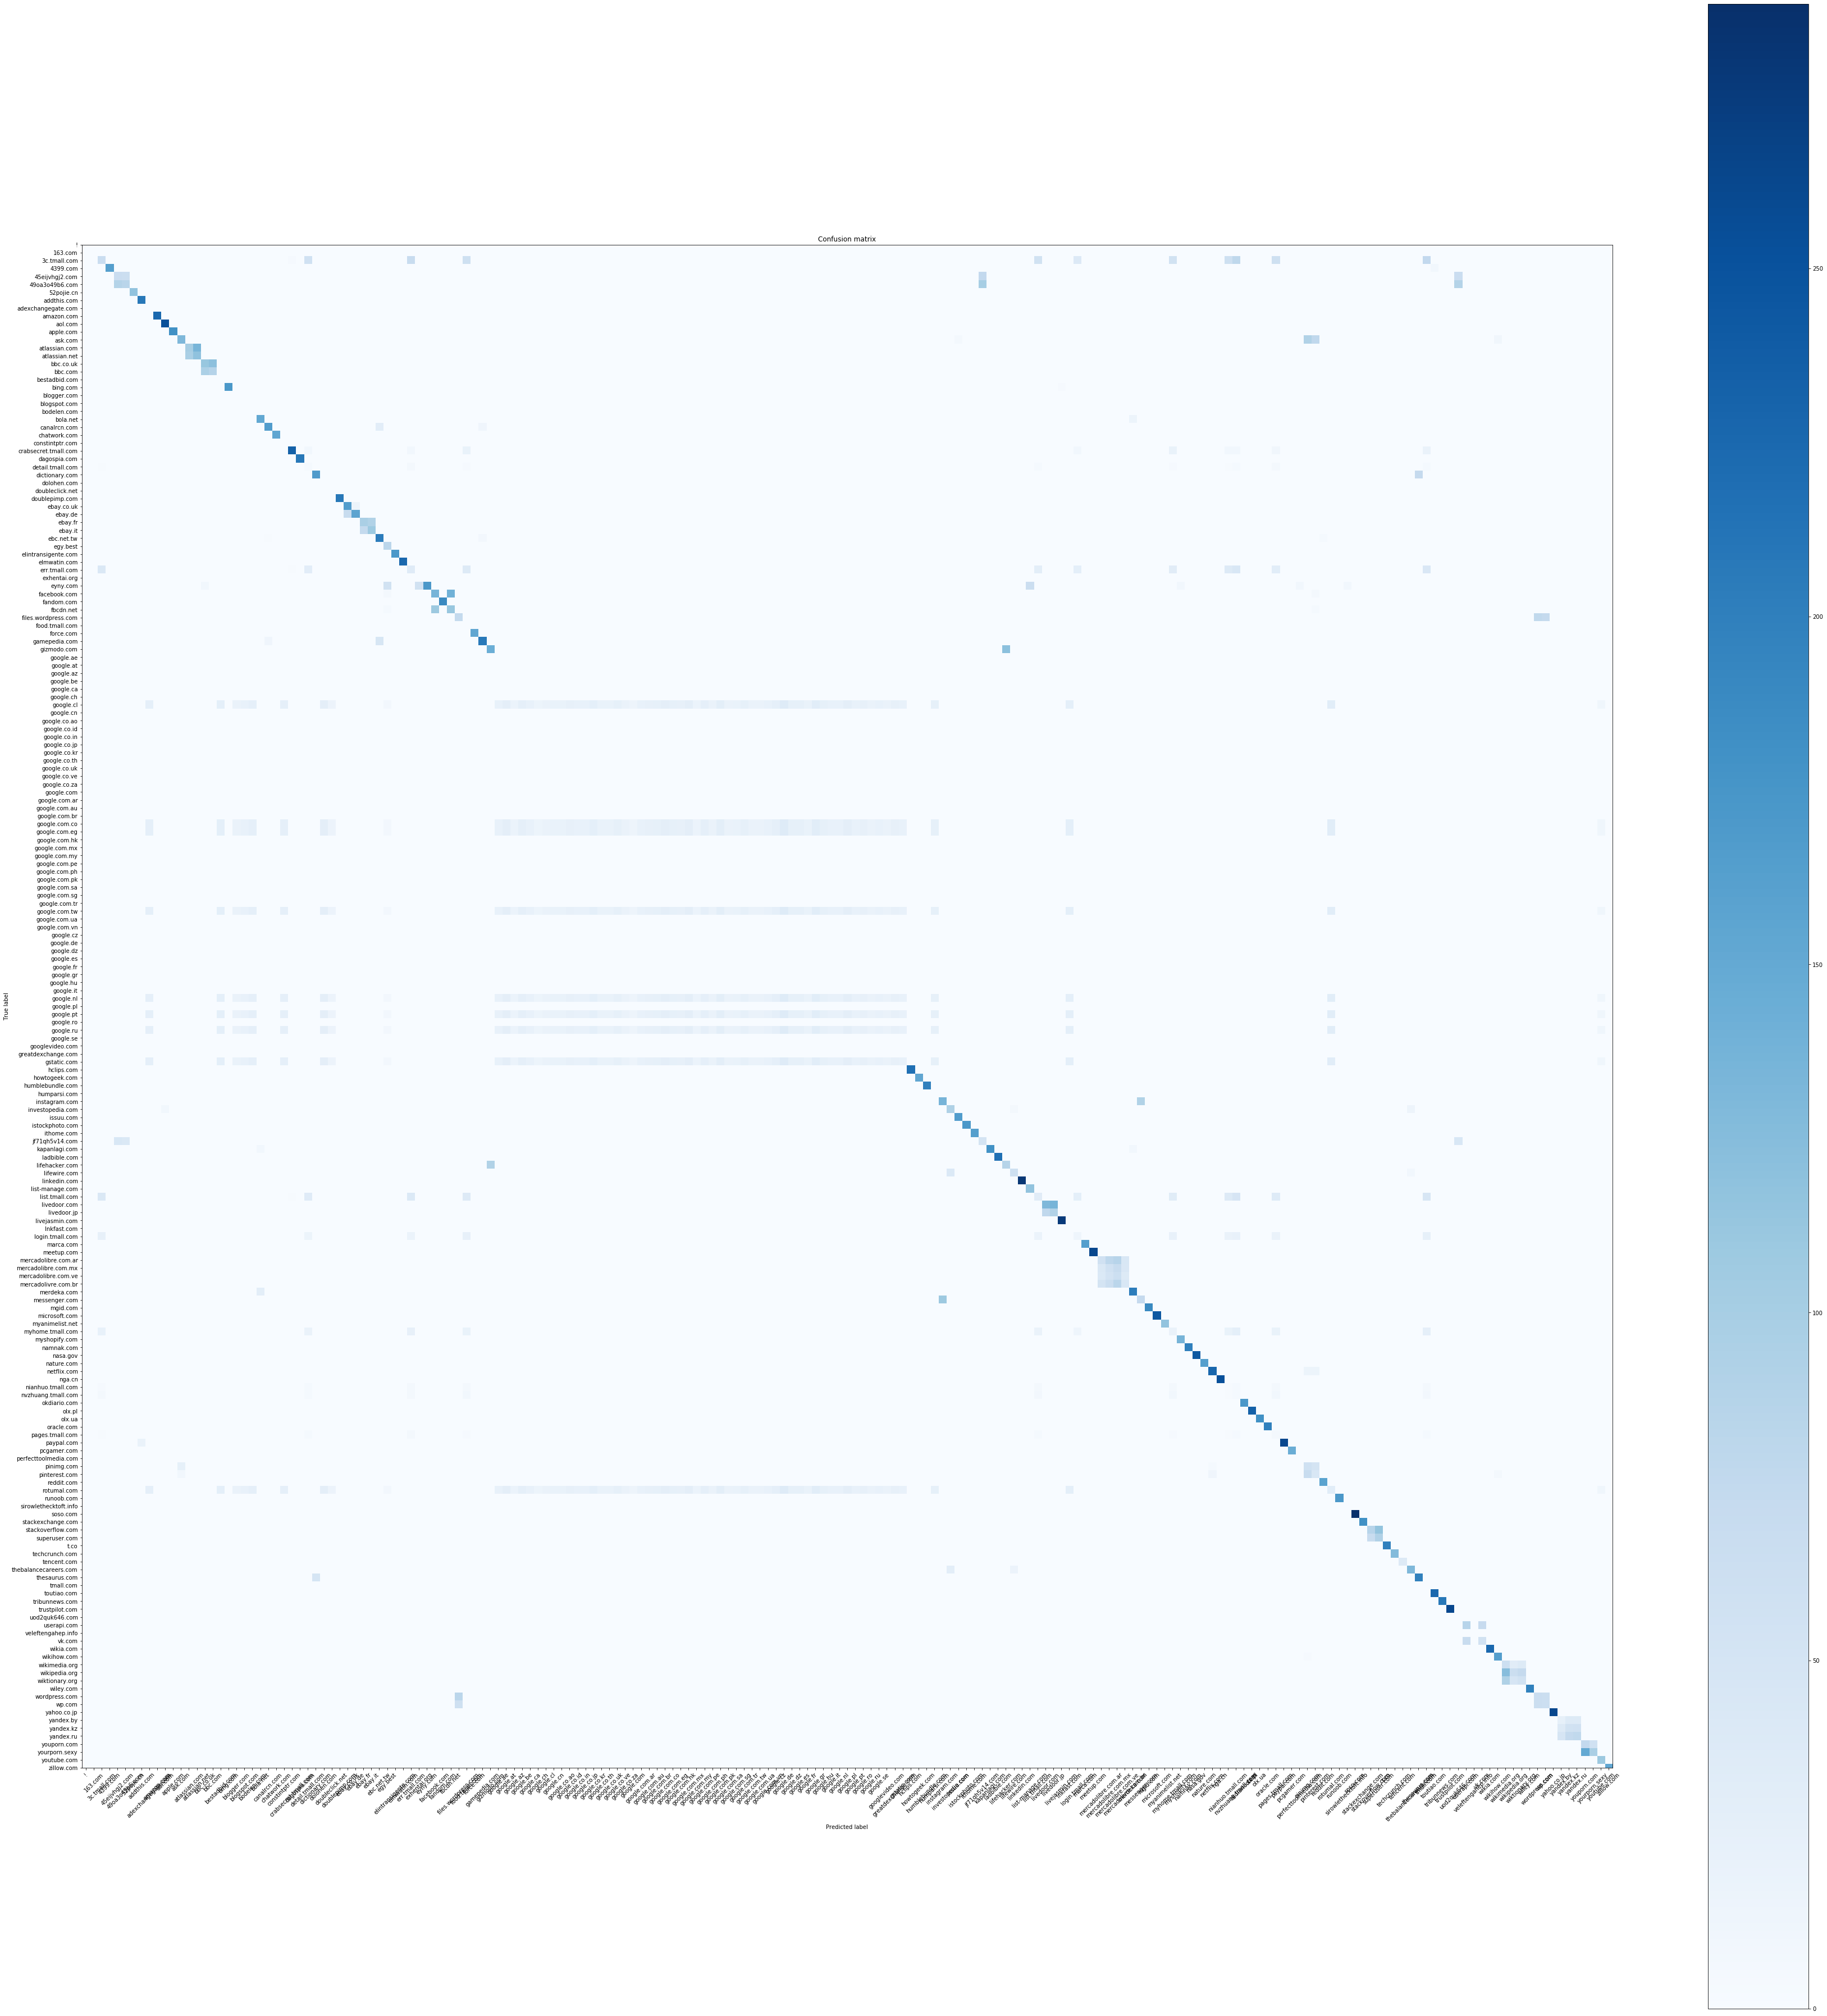

In [199]:
fig = plt.gcf()
fig.set_size_inches(50, 50)
fig.savefig("asn"+str(datetime.date(datetime.now()))+".png", dpi=100)
plot_confusion_matrix(conf_matrix, le_labels.classes_, "asn", False)

In [200]:
print(labels_to_predicted_asn)

{'4399.com': {'4399.com'}, 'gamepedia.com': {'gamepedia.com', 'canalrcn.com', 'ebc.net.tw'}, 'google.com': {'google.com.tw', 'google.com.co', 'rotumal.com', 'gstatic.com', 'google.pt', 'google.ru', 'google.com.eg', 'google.cl', 'google.nl'}, 'lifewire.com': {'thebalancecareers.com', 'investopedia.com', 'lifewire.com'}, 'constintptr.com': {'google.com.tw', 'google.com.co', 'rotumal.com', 'gstatic.com', 'google.pt', 'google.ru', 'google.com.eg', 'google.cl', 'google.nl'}, 'google.com.mx': {'google.com.tw', 'google.com.co', 'rotumal.com', 'gstatic.com', 'google.pt', 'google.ru', 'google.com.eg', 'google.cl', 'google.nl'}, 'chatwork.com': {'chatwork.com'}, 'nvzhuang.tmall.com': {'list.tmall.com', 'detail.tmall.com', 'login.tmall.com', 'myhome.tmall.com', '3c.tmall.com', 'err.tmall.com', 'crabsecret.tmall.com', 'nvzhuang.tmall.com', 'pages.tmall.com', 'nianhuo.tmall.com'}, 'pages.tmall.com': {'list.tmall.com', 'detail.tmall.com', 'login.tmall.com', 'myhome.tmall.com', '3c.tmall.com', 'err.t